In [1]:
!pip install scikit-maad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 134 kB 8.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
!pip install kymatio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.4 MB/s 


In [3]:
import torch

from torch.nn import Linear, NLLLoss, LogSoftmax, Sequential
from torch.optim import Adam

from scipy.io import wavfile
import os
import numpy as np

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [4]:
from kymatio.torch import Scattering1D
from kymatio.datasets import fetch_fsdd

In [5]:
# First, we have signal length. Longer signals are truncated and shorter signals are zero-padded. 
# The sampling rate is 8000 Hz, so this corresponds to little over a second.

T = 2**13
# Maximum scale 2**J of the scattering transform (here, about 30 milliseconds) and the number of wavelets per octave.

J = 8
Q = 12
# We need a small constant to add to the scattering coefficients before computing the logarithm. This prevents very large values when the scattering coefficients are very close to zero.

log_eps = 1e-6
#If a GPU is available, let’s use it!
use_cuda = torch.cuda.is_available()
#For reproducibility, we fix the seed of the random number generator.
torch.manual_seed(42)

In [6]:
info_data = fetch_fsdd()
files = info_data['files']
path_dataset = info_data['path_dataset']

In [7]:
x_all = torch.zeros(len(files), T, dtype=torch.float32)
y_all = torch.zeros(len(files), dtype=torch.int64)
subset = torch.zeros(len(files), dtype=torch.int64)

In [8]:

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns

from librosa import feature
from maad import sound
from time import time
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


sns.set_theme()
plt.rcParams["figure.figsize"] = (17, 5)

In [9]:
from maad import util, sound, features

from maad.util import power2dB, plot2d
from skimage import transform
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF

In [10]:
### librosa
import librosa as lr
import librosa.display

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
def transform(s, fs, wtype='hann', nperseg=512, noverlap=0, db_range=60, db_gain=30):
    """ Compute decibel spectrogram """
    Sxx, tn, fn, ext = sound.spectrogram(s, fs, wtype, nperseg, noverlap)            
    Sxx = util.power2dB(Sxx, db_range, db_gain)
    return Sxx, tn, fn, ext

In [24]:
#%% Set variables
path_annotations = '/content/drive/MyDrive/Nube/DS4All - Cohort6 - Team 172/Code/data/ANH_RAIN_DATASET/audio_labels.csv'  # manual annotations in csv table
path_audio = '/content/drive/MyDrive/Nube/DS4All - Cohort6 - Team 172/Code/data/ANH_RAIN_DATASET/audio/'  # directory where the audio data is located
path_results = '/content/drive/MyDrive/DS4All - Cohort6 - Team 172/Code/results/'
target_fs = 10000  # set target sampling rate for audio

In [14]:
#%% Load annotations
df = pd.read_csv(path_annotations)  

In [15]:
df.shape

(1104, 7)

In [16]:
df.head()

,fname,label,max_f,max_t,min_f,min_t,sample_idx
0,G001_20211112_030000.WAV,SENSAT,47297.562,5.0,47297.562,0.0,0000.wav
1,G001_20211112_180000.WAV,MURCIE,44956.098,5.0,24819.512,0.0,0001.wav
2,G001_20211112_183000.WAV,INSECT,51980.490,5.0,3721.417,0.0,0002.wav
3,G001_20211112_203000.WAV,MURCIE,33482.926,5.0,16776.250,0.0,0003.wav
4,G001_20211112_220000.WAV,SENSAT,24585.365,5.0,24585.365,0.0,0004.wav


In [17]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

classifier = LogisticRegression(penalty='l1',class_weight='balanced',max_iter=2666,solver='saga')

# Pipeline, should we normalize/standarize?
pipe = Pipeline ([#("cleaner", predictors()),
                 #("standarize", ),
                 ("classifier", classifier)])

In [18]:
# Classifiers to use
clfs = [LinearSVC(class_weight='balanced'),
        SGDClassifier(class_weight='balanced'),
        SVC(kernel='rbf',degree=3,gamma='scale',class_weight='balanced'),
        LogisticRegression(penalty='l1',class_weight='balanced',solver='saga'),
        DecisionTreeClassifier(class_weight='balanced'),
        RandomForestClassifier(class_weight='balanced'),
        GradientBoostingClassifier()]



*   https://www.kymat.io/userguide.html
*   https://www.kymat.io/gallery_1d/plot_classif_torch.html#sphx-glr-gallery-1d-plot-classif-torch-py
*   https://www.kymat.io/gallery_1d/plot_real_signal.html#sphx-glr-gallery-1d-plot-real-signal-py
*   https://scikit-maad.github.io/_auto_examples/2_advanced/plot_nmf_and_false_color_spectrogram.html#sphx-glr-auto-examples-2-advanced-plot-nmf-and-false-color-spectrogram-py
*   https://github.com/juansulloa/putumayo_soundmarks/blob/572da1337f56d4b23bf4774e2515c64b01c108bb/scripts/utils.py
*   https://scikit-maad.github.io/features.html
*   https://scikit-maad.github.io/util.html

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fname       1104 non-null   object 
 1   label       1104 non-null   object 
 2   max_f       1104 non-null   float64
 3   max_t       1104 non-null   float64
 4   min_f       1104 non-null   float64
 5   min_t       1104 non-null   float64
 6   sample_idx  1104 non-null   object 
dtypes: float64(4), object(3)
memory usage: 60.5+ KB


In [31]:
#for idx_row, row in df.iterrows():
#  print(idx_row)
#  print(row)

full_path_audio = os.path.join(path_audio, row.sample_idx)
full_path_audio

full_path_audio = os.path.join(path_audio, row.sample_idx)

s, fs = sound.load(full_path_audio)

times = np.arange(0, len(s))/fs

cent = librosa.feature.spectral_centroid(y=s, sr=fs)
S1, phase = librosa.magphase(librosa.stft(y=s))

phase

array([[ 1.        +0.00000000e+00j,  1.        +0.00000000e+00j,
         1.        +0.00000000e+00j, ...,  1.        +0.00000000e+00j,
         1.        +0.00000000e+00j, -1.        +1.22464680e-16j],
       [-1.        -1.22464680e-16j, -0.95778068-2.87499852e-01j,
        -0.41487504-9.09878397e-01j, ...,  0.01884563+9.99822405e-01j,
        -0.93851858-3.45228731e-01j,  0.55724201-8.30350135e-01j],
       [-1.        +1.22464680e-16j,  0.64238798+7.66379597e-01j,
         0.87499338-4.84134882e-01j, ..., -0.96427654-2.64897616e-01j,
         0.99115345+1.32720914e-01j, -0.04319268+9.99066761e-01j],
       ...,
       [ 1.        -8.67828843e-16j, -0.99985898-1.67934564e-02j,
        -0.19741806+9.80319392e-01j, ...,  0.44205269-8.96989084e-01j,
        -0.87984446+4.75261740e-01j,  0.49924183-8.66462689e-01j],
       [-1.        -3.23108915e-15j,  0.00920374+9.99957645e-01j,
        -0.24283699-9.70067108e-01j, ..., -0.97763106+2.10327141e-01j,
        -0.69595237+7.18087944e-01j

In [39]:
Sxx, tn, fn, ext = transform(s, fs, nperseg=1024, noverlap=512) #db_range, db_gain)
# compute shape features
shape, params = features.shape_features(Sxx)
shape

,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,shp_007,shp_008,shp_009,shp_010,shp_011,shp_012,shp_013,shp_014,shp_015,shp_016
0,0.174622,0.175192,0.052616,0.055662,0.123415,0.119934,0.03599,0.033584,0.083825,0.075448,0.034093,0.025699,0.08433,0.066282,0.049177,0.028975


In [42]:
#%% Compute features
df_features = pd.DataFrame()

scores = {"Annotation":[],
          "Classifier":[],
          "Features": [],
          "Feature Extraction Time":[],
          "Metric Score":[],
          "Performance": [],
          "Classifier Time":[],
          }

### list to 
medrms = []
stdrms = []

medcen = []
stdcen = []

medbw = []
stdbw = []

medrllf = []
stdrllf = []

medflt = []
stdflt = []

medcnt = []
stdcnt = []



scoring = ["f1", "balanced_accuracy","roc_auc"]
#%% Compute features
df_features = pd.DataFrame()
# Calculate for each feature, time of extraction

# read idx_row = information in rows, rows = index (integer)
for idx_row, row in df.iterrows():
    t0_features = time()
    ## file location
    full_path_audio = os.path.join(path_audio, row.sample_idx)
    s, fs = sound.load(full_path_audio)
    
    # resample
    s_resamp = sound.resample(s, fs, target_fs, res_type='kaiser_fast')
    # transform

    # Spectral features
    ## with librosa
    #audio, freq = lr.load(full_path_audio)

    # 5 features 
    ## zero crossing
    CZ = sum(librosa.zero_crossings(s, pad=False))
    row = row.append(pd.Series(CZ, index='CZ'))

    #cent = librosa.feature.spectral_centroid(y=s, sr=fs)
    #S1, phase = librosa.magphase(librosa.stft(y=s))





    # Temporal features

    # 

    # Wavelets features


    ##
    
    # Mel-frequency cepstral coefficients (MFCCs)
    
    
    mfcc = feature.mfcc(y=s_resamp, sr=target_fs, n_mfcc=20, n_fft=1024, 
                        win_length=1024, hop_length=512, htk=True)
    mfcc = np.median(mfcc, axis=1)
    # format dataframe
    idx_names = ['mfcc_' + str(idx).zfill(2) for idx in range(1,mfcc.size+1)]
    row = row.append(pd.Series(mfcc, index=idx_names))
    row.name = idx_row
    

    # Format the output as an array for decomposition
    Sxx, tn, fn, ext = transform(s, fs, nperseg=1024, noverlap=512) #db_range, db_gain)
    # compute shape features
    shape, params = features.shape_features(Sxx)
    
    all_features = row.append(shape.squeeze(axis=0))
    df_features = df_features.append(all_features,ignore_index=True)
  

duration = round(time() - t0_features,2)
scores["Feature Extraction Time"].extend([duration]*len(clfs)*n_splits*len(scoring))
print('Feature:', 'Extraction Time:',duration)
scores["Features"].extend(['mfcc']*len(clfs)*n_splits*len(scoring))

TypeError: ignored

In [38]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 43 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fname       16 non-null     object 
 1   label       16 non-null     object 
 2   max_f       16 non-null     float64
 3   max_t       16 non-null     float64
 4   min_f       16 non-null     float64
 5   min_t       16 non-null     float64
 6   sample_idx  16 non-null     object 
 7   mfcc_01     16 non-null     float64
 8   mfcc_02     16 non-null     float64
 9   mfcc_03     16 non-null     float64
 10  mfcc_04     16 non-null     float64
 11  mfcc_05     16 non-null     float64
 12  mfcc_06     16 non-null     float64
 13  mfcc_07     16 non-null     float64
 14  mfcc_08     16 non-null     float64
 15  mfcc_09     16 non-null     float64
 16  mfcc_10     16 non-null     float64
 17  mfcc_11     16 non-null     float64
 18  mfcc_12     16 non-null     float64
 19  mfcc_13     16 non-null     flo

In [36]:
df_features.head()

,fname,label,max_f,max_t,min_f,min_t,sample_idx,mfcc_01,mfcc_02,mfcc_03,...,shp_007,shp_008,shp_009,shp_010,shp_011,shp_012,shp_013,shp_014,shp_015,shp_016
0,G001_20211112_030000.WAV,SENSAT,47297.562,5.0,47297.562,0.0,0000.wav,-364.480284,14.626889,-9.040904,...,0.060653,0.056473,0.040989,0.043577,0.057307,0.047118,0.024734,0.024005,0.068497,0.050387
1,G001_20211112_180000.WAV,MURCIE,44956.098,5.0,24819.512,0.0,0001.wav,-459.676892,23.274923,29.334150,...,0.035191,0.030448,0.021611,0.020820,0.038616,0.028099,0.014909,0.013870,0.054179,0.032217
2,G001_20211112_183000.WAV,INSECT,51980.490,5.0,3721.417,0.0,0002.wav,-430.154709,12.203873,39.103408,...,0.049311,0.042528,0.028967,0.028245,0.054352,0.042448,0.021207,0.019887,0.071560,0.048007
3,G001_20211112_203000.WAV,MURCIE,33482.926,5.0,16776.250,0.0,0003.wav,-461.207384,9.153970,35.270469,...,0.039639,0.034975,0.023664,0.022734,0.043355,0.031397,0.016937,0.015713,0.068470,0.044211
4,G001_20211112_220000.WAV,SENSAT,24585.365,5.0,24585.365,0.0,0004.wav,-442.703396,8.661459,22.384752,...,0.052650,0.046274,0.035858,0.035117,0.056288,0.043156,0.023940,0.021407,0.083811,0.057447


In [ ]:
df_features['label'] = df_features['label'].replace({'SENSAT':'Saturated',
                                                    'MURCIE':'Bats',
                                                    'INSECT':'Insects',
                                                    'LLUVIA':'Rain',
                                                    'PULSOS':'Pulses', 
                                                    'HERPET':'Amphibian',
                                                    'ANTROP':'Anthrophony',
                                                    'AVEVOC':'Birds', 
                                                    'TRAMOT':'Anthrophony',#'Motors',#'Transporte Motorizado', 
                                                    'INDETE':'Undetermined', 
                                                    'PASOS': 'Footsteps', #'Pasos', 
                                                    'FLUAGU':'Rainfall',
                                                    'ANIDOM': 'Domestic Animals' #'Animales Domésticos'
                                                     })


"""
SENSAT: Señal saturada
MURCIE: Murcélagos
INSECT: Insectos
LLUVIA: lluvia
PULSOS: Esto es un ruido raro que nos encontramos y que creemos que está asociado a las hormigas comiendo una membrana del micrófono en los equipos. Pueden convertirla en INTERF: interferencia. Ya que en estas grabaciones no se está grabando un paisaje sonoro sino un ruido.
HERPET: herpetos. En 99% de los casos son anfibios vocalizando.
ANTROP: Antropofonía. Este sería bueno descomponerlo en Transporte Motorizado, Construcción, etc. Aunque casi siempre es transporte motorizado.
AVEVOC: Vocalizacion de aves
TRAMOT: Transporte motorizado, a juntar con atropofonía.
INDETE: Indeterminado, no sabemos que es, si es ave, insecto o anfibio o mamífero.
FLUAGU: Flujo de agua
ANIDOM: Animales domésticos.
"""

In [ ]:
df_features['label'].value_counts(normalize=True)

In [ ]:
scores = {"Annotation":[],
          "Feature": [],
          "Classifier":[],
          "Metric Score":[],
          "Performance": [],
          "Classifier Time":[],
          }

for feature in ['mfcc','shp' ]:
    for label_name in ['Rain','Insects','Birds','Bats','Anthrophony','Amphibian']:
        #%% Split development and test data
        print('-----------------------------------Analysis of category:',label_name,'-----------------------------------')
        X = df_features[[i for i in df_features.columns if feature in i]]
        y = (df_features.label==label_name).astype(int)
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.3, 
                                                            shuffle=True,
                                                            random_state=42) 
        
        for classifier in tqdm(clfs):
              print('-----------------------------------',classifier)
              t0 = time()
              print(str(classifier))
              pipe.set_params(classifier = classifier)
              cv_result = cross_validate(pipe, X_train, y_train, scoring=scoring,cv=skf)
              
              metrics = [i for i in cv_result.keys() if 'test' in i]
              n_metrics = len(metrics)

              for metric in metrics:
                  scores["Performance"].extend(cv_result[metric])
                  scores["Metric Score"].extend([metric.split('test_')[-1]]*n_splits)
                  scores["Classifier"].extend([str(classifier).split('(')[0]]*n_splits)
                  scores["Annotation"].extend([label_name]*n_splits)
                  scores["Feature"].extend([feature]*n_splits)
   
              duration = round(time() - t0,2)
              print('---------------------------------','duration:',duration)
              scores["Classifier Time"].extend([duration]*n_metrics*n_splits)
              for key, values in cv_result.items():
                      print(key,' mean ', values.mean())
                      print(key,' std ', values.std())

              #save in each running to avoid execution without saving
                        
        df_scores = pd.DataFrame(scores)
        df_scores.to_csv(path_results+'results.csv',index=False) ## ad descriptive name a nd date


        ### Add feature importance 

In [ ]:
df_scores

,Annotation,Feature,Classifier,Metric Score,Performance,Classifier Time
0,Rain,mfcc,LinearSVC,f1,0.769231,0.33
1,Rain,mfcc,LinearSVC,f1,0.800000,0.33
2,Rain,mfcc,LinearSVC,f1,0.361290,0.33
3,Rain,mfcc,LinearSVC,f1,0.842105,0.33
4,Rain,mfcc,LinearSVC,f1,0.851852,0.33
...,...,...,...,...,...,...
1255,Amphibian,shp,GradientBoostingClassifier,roc_auc,0.657333,1.79
1256,Amphibian,shp,GradientBoostingClassifier,roc_auc,0.609333,1.79
1257,Amphibian,shp,GradientBoostingClassifier,roc_auc,0.746667,1.79
1258,Amphibian,shp,GradientBoostingClassifier,roc_auc,0.837584,1.79


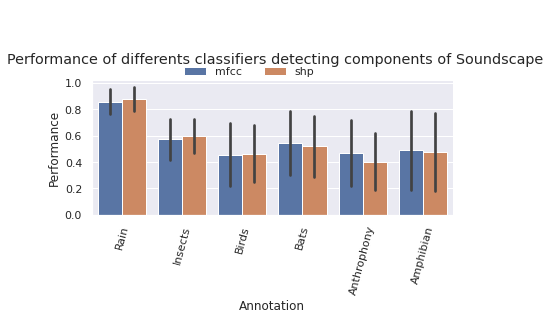

In [ ]:
ax = sns.catplot(data=df_scores,x='Classifier',y='Performance',hue='Metric Score', kind='bar',
                 ci="sd",col="Annotation",col_wrap=3,
                 height=3, aspect=2)

ax.fig.subplots_adjust(top=0.85)
ax.fig.suptitle('Performance of differents classifiers detecting components of Soundscape', 
                fontdict = {'fontsize' : 25})

sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.08), ncol=3, title=None, frameon=False,)
ax.set_xticklabels(rotation=75)
plt.show()



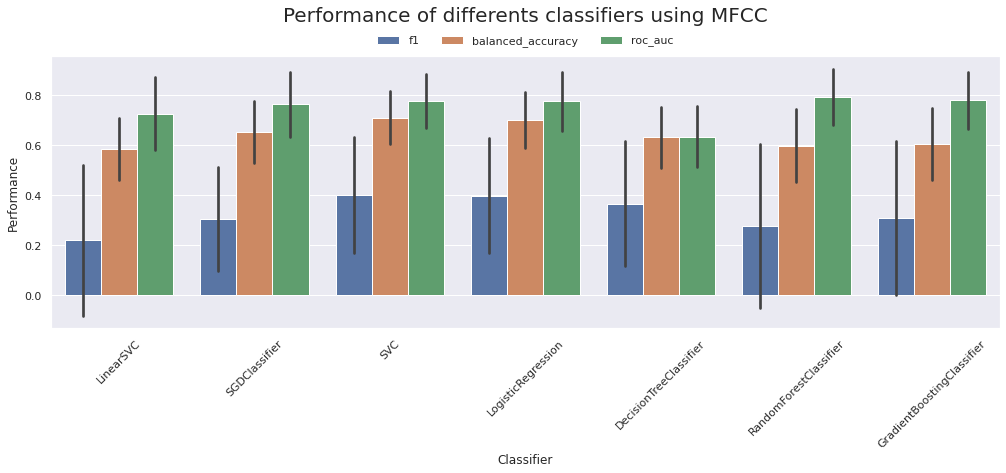

In [ ]:
ax = sns.barplot(data=df_scores,x='Classifier',y='Performance',hue='Metric Score',ci="sd")
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
ax.set_title('Performance of differents classifiers using MFCC', fontdict = {'fontsize' : 20}, pad=35)
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_scores.groupby(['Classifier','Metric Score'])['Performance'].agg(['mean', 'std'])

mean       std
Classifier                 Metric Score                         
DecisionTreeClassifier     balanced_accuracy  0.631995  0.124464
                           f1                 0.365600  0.256094
                           roc_auc            0.632509  0.124403
GradientBoostingClassifier balanced_accuracy  0.604172  0.147072
                           f1                 0.308020  0.313152
                           roc_auc            0.779095  0.116333
LinearSVC                  balanced_accuracy  0.583864  0.128048
                           f1                 0.218132  0.307258
                           roc_auc            0.725627  0.148117
LogisticRegression         balanced_accuracy  0.700063  0.115049
                           f1                 0.397735  0.235653
                           roc_auc            0.774542  0.121617
RandomForestClassifier     balanced_accuracy  0.597764  0.148843
                           f1                 0.275359  0.332937
                           roc_auc            0.793944  0.114038
SGDClassifier              balanced_accuracy  0.651155  0.125855
                           f1                 0.303404  0.211147
                           roc_auc            0.763017  0.132937
SVC                        balanced_accuracy  0.710277  0.108647
                           f1                 0.399211  0.235837
                           roc_auc            0.776766  0.110702

In [ ]:
df_scores['Classifier'] = df_scores['Classifier'].replace({'LinearSVC':'Linear SVC',
                                                    'SGDClassifier':'SGD',
                                                    'LogisticRegression':'Logistic Regression',
                                                    'DecisionTreeClassifier':'Decision Tree',
                                                    'RandomForestClassifier':'Random Forest', 
                                                    'GradientBoostingClassifier':'Gradient Boosting',
                            
                                                     })

df_scores['Metric Score'] = df_scores['Metric Score'].replace({'f1':'F1',
                                                    'roc_auc':'ROC AUC',
                                                    'balanced_accuracy':'Accuracy',

                            
                                                     })

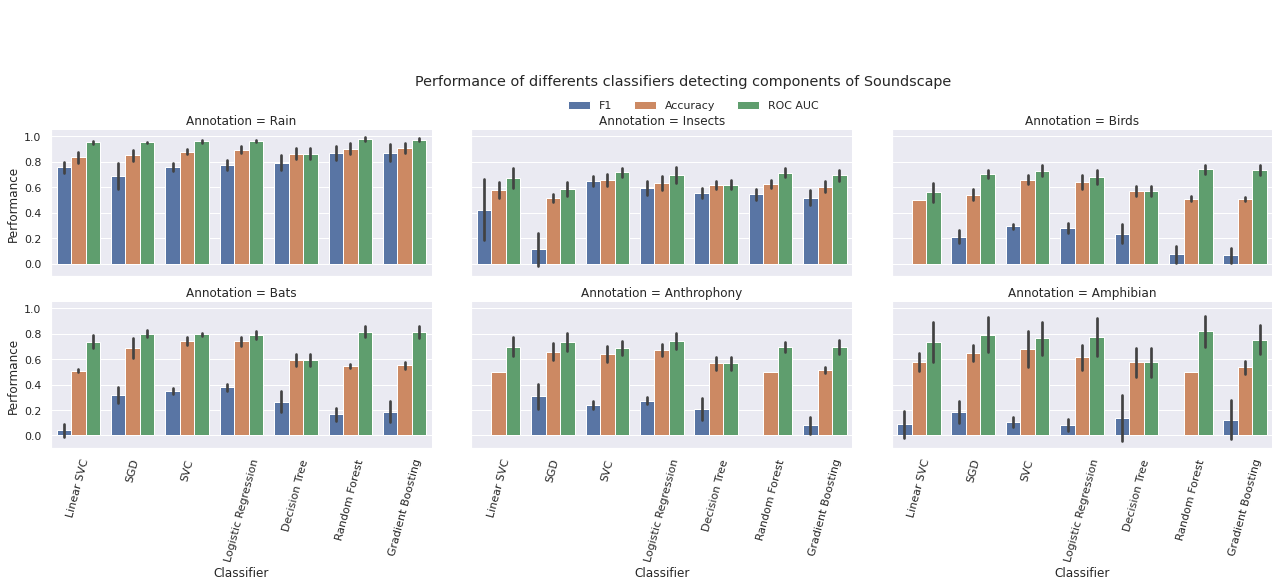

In [ ]:
ax = sns.catplot(data=df_scores,x='Classifier',y='Performance',hue='Metric Score', kind='bar',
                 ci="sd",col="Annotation",col_wrap=3,
                 height=3, aspect=2)

ax.fig.subplots_adjust(top=0.85)
ax.fig.suptitle('Performance of differents classifiers detecting components of Soundscape', 
                fontdict = {'fontsize' : 25})

sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.08), ncol=3, title=None, frameon=False,)
ax.set_xticklabels(rotation=75)
plt.show()

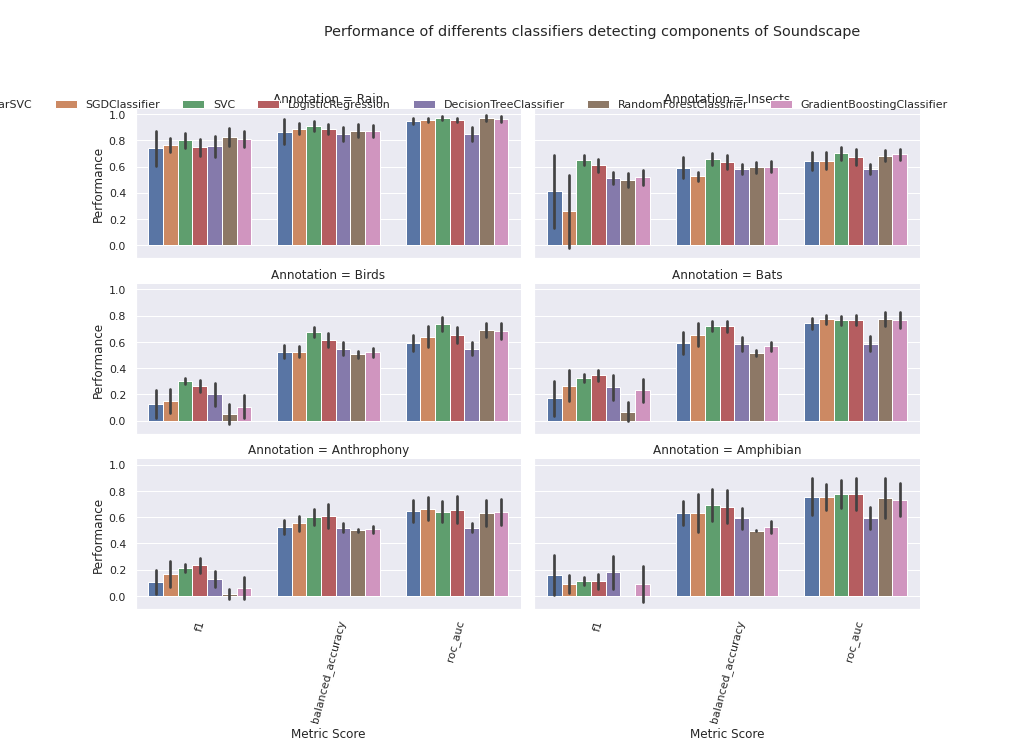

In [ ]:
ax = sns.catplot(data=df_scores,hue='Classifier',y='Performance',x='Metric Score', kind='bar',
                 ci="sd",col="Annotation",col_wrap=2,
                 height=3, aspect=2)

ax.fig.subplots_adjust(top=0.85)
ax.fig.suptitle('Performance of differents classifiers detecting components of Soundscape', 
                fontdict = {'fontsize' : 25})

sns.move_legend(ax, "lower center", bbox_to_anchor=(.425, 0.97), ncol=7, title=None, frameon=False,)
ax.set_xticklabels(rotation=75)
plt.show()

In [ ]:
df_scores.groupby(['Annotation','Classifier','Metric Score'])['Performance'].agg(['mean', 'std'])

mean       std
Annotation Classifier        Metric Score                    
Amphibian  Decision Tree     Accuracy      0.576311  0.126151
                             F1            0.136752  0.205484
                             ROC AUC       0.576880  0.127035
           Gradient Boosting Accuracy      0.535991  0.057037
                             F1            0.123810  0.170367
...                                             ...       ...
Rain       SGD               F1            0.689253  0.111149
                             ROC AUC       0.953581  0.003983
           SVC               Accuracy      0.879132  0.022351
                             F1            0.757849  0.036751
                             ROC AUC       0.961033  0.011123

[126 rows x 2 columns]

-----------------------------------Analysis of category: Rain -----------------------------------


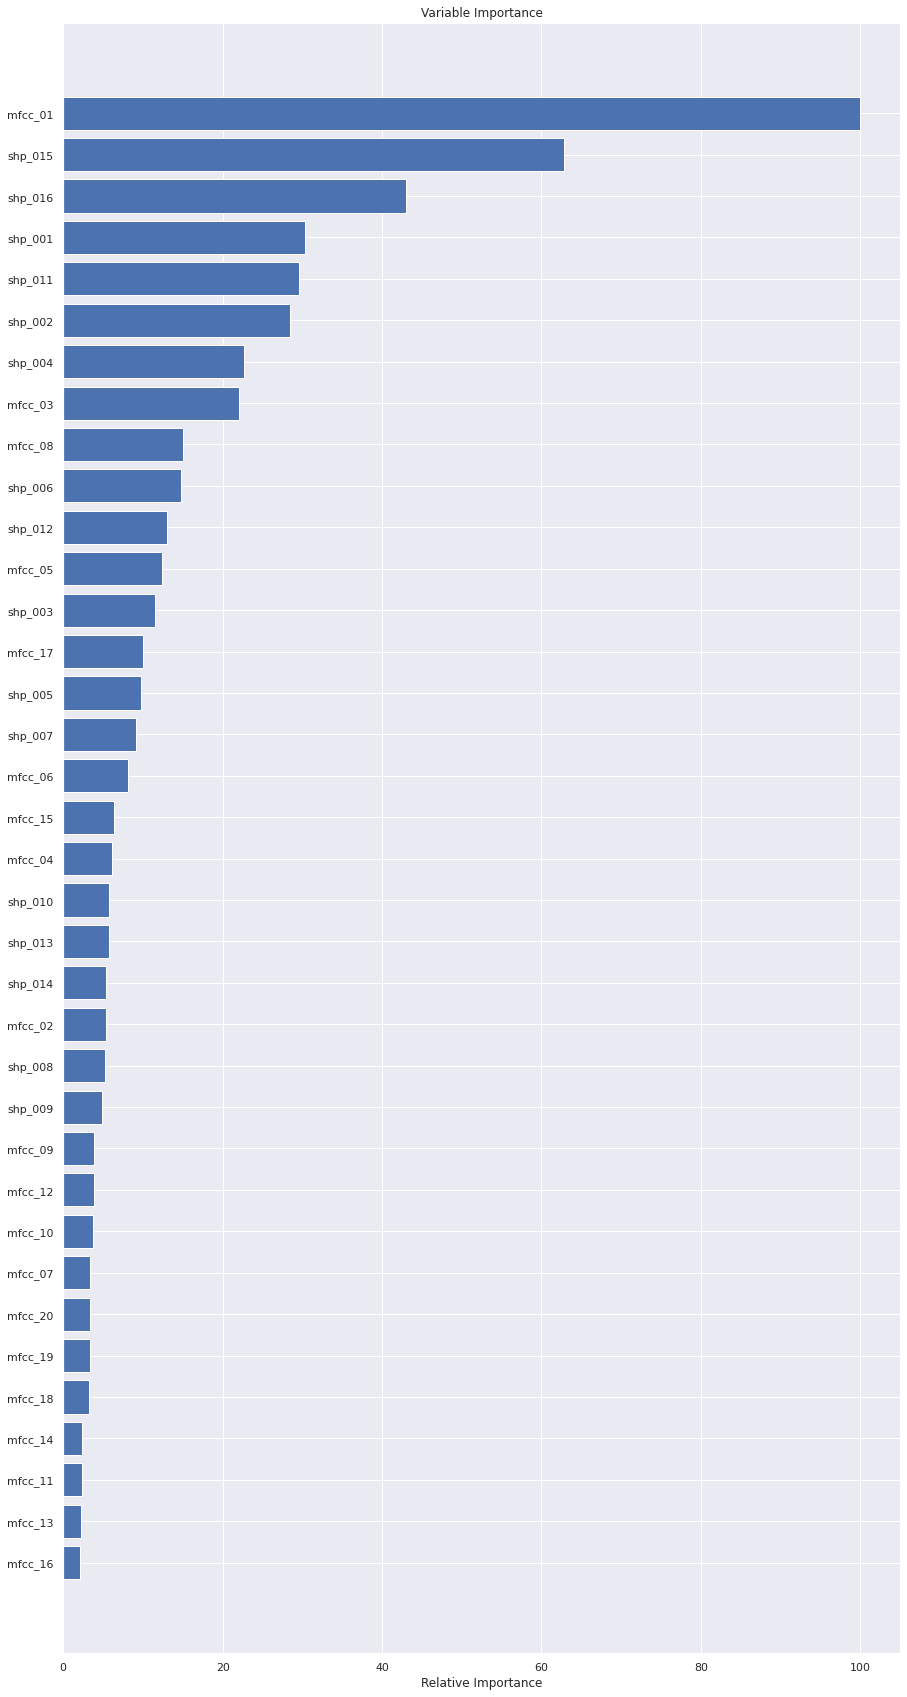

In [ ]:
for label_name in ['Rain']:#'Insects','Birds','Bats','Anthrophony','Amphibian']:

    fea_importances = []

    #%% Split development and test data
    print('-----------------------------------Analysis of category:',label_name,'-----------------------------------')

    X = df_features[[i for i in df_features.columns if 'mfcc' in i or 'shp' in i]]
    y = (df_features.label==label_name).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.3, 
                                                        shuffle=True,
                                                        random_state=42) 
    
    model = RandomForestClassifier(class_weight='balanced') #GradientBoostingClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    # Plot feature importance
    feature_importance = model.feature_importances_
    fea_importances.append(feature_importance)
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(15, 30))
    pos = np.arange(sorted_idx.shape[0]) + .8
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
#             plt.savefig('GBRT_graphs' + str(NUM_TEST_PER_USER) + '/mixed_all/' + feature_sets_names[i] + '/' + str(count) + '.png', bbox_inches='tight')
    plt.show()





*   https://scikit-learn.org/stable/modules/ensemble.html#feature-importance
*   https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
*   https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
*   https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance
*   https://christophm.github.io/interpretable-ml-book/feature-importance.html
*   https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
*   https://scikit-learn.org/stable/modules/permutation_importance.html

In [ ]:
feature_importance

array([100.        ,   5.37179341,  22.04537511,   6.06542696,
        12.371292  ,   8.0730267 ,   3.41028672,  15.0677093 ,
         3.892315  ,   3.76088058,   2.31996081,   3.83650048,
         2.26068996,   2.39806245,   6.3130099 ,   2.11336685,
         9.99061923,   3.29171275,   3.31272434,   3.33696233,
        30.28676636,  28.43407843,  11.45546017,  22.64226813,
         9.70618412,  14.78565682,   9.17348113,   5.27751152,
         4.87415836,   5.72257758,  29.63734179,  12.9882933 ,
         5.71401166,   5.41117155,  62.82026026,  42.96326742])

In [ ]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

IndentationError: ignored